In [1]:
% matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# we can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save referenes to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session link from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

## 1) Precipitation Analysis

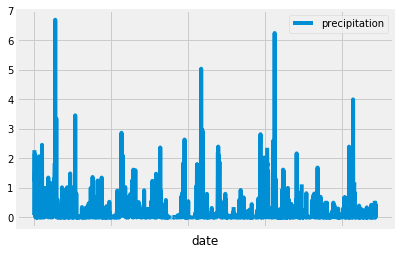

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).\
order_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.read_sql(prcp_data.statement, con=engine)
prcp_df.set_index(prcp_df["date"],inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x_compat=True)
plt.xlabel("date")
plt.legend(["precipitation"])

In [11]:
# set the x_axis
# date_x_axis = np.arange(0, len(prcp_df.date), step=200)
# date_tick_locations = []
# for x in date_x_axis:
#     date_tick_locations.append(x)
# plt.xticks(date_tick_locations, prcp_df.date.iloc[date_tick_locations], rotation=45)

In [12]:
# Use Pandas to print the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## 2) Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {number_of_stations} stations in this dataset")

There are 9 stations in this dataset


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_id = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()[0]
temperature_list = [
    session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all(),
    session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all(),
    session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all()
]
print(temperature_list)

[[(54.0,)], [(85.0,)], [(71.66378066378067,)]]


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_tobs_station_id = session.query(Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()[0]

temperature_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year_ago).\
filter(Measurement.station==highest_tobs_station_id).order_by(Measurement.date)

# Save into pandas
temperature_df = pd.read_sql(temperature_data.statement, con=engine)

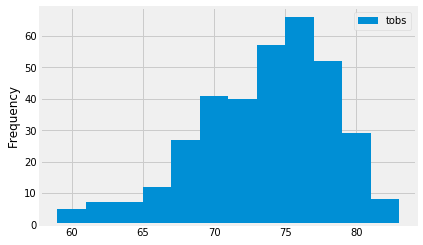

In [33]:
temperature_df.plot.hist(bins=12)

## 3) Temperature Analysis (Optional)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-01-01'
end_date = '2017-01-15'
calc_temps(start_date, end_date)

[(60.0, 68.5505617977528, 81.0)]

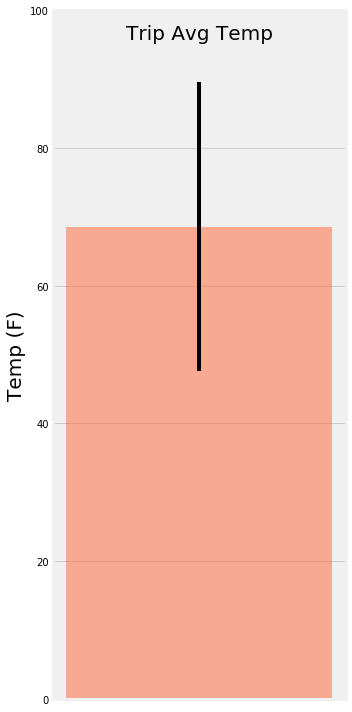

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(5, 10))
plt.bar(x=0, height=calc_temps(start_date, end_date)[0][1],
        yerr=calc_temps(start_date, end_date)[0][2]-calc_temps(start_date, end_date)[0][0], 
        color=(1, 0.4, 0.2, 0.5))
plt.ylim(0, 100)
plt.title("Trip Avg Temp", y=0.95, fontsize=20)
plt.ylabel("Temp (F)", fontsize=20)
plt.xticks([])
plt.tight_layout()

In [39]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
print(session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all())

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
trip_dates = []
dates = []
for date in pd.date_range(start=start_date, end=end_date):
    trip_dates.append(date.strftime("%Y-%m-%d"))
    dates.append(date.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in dates:
    normals.append(daily_normals(date)[0])

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_df = pd.DataFrame(data=normals, columns=['tmin', 'tavg', 'tmax'], index=trip_dates)

Text(0.5,0,'date')

<Figure size 7200x4800 with 0 Axes>

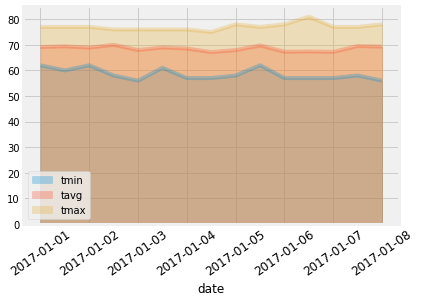

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(dpi=1200)
trip_normals_df.plot(kind='area', stacked=False, alpha=0.3)
trip_date_tick_locations = []
for x in np.arange(len(trip_dates), step=2):
    trip_date_tick_locations.append(x)
plt.xticks(trip_date_tick_locations, trip_dates, rotation=35, fontsize=12)
plt.xlabel("date")